In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [11]:
# Load the data
nl_df = pd.read_csv('/Users/jesselemeer/Documents/GitHub/Project2-2/Project_2-2/NL_data/train_set/processed_data.csv')

# Filter data for Amsterdam
ams_df = nl_df[(nl_df['latitude'] == 52.25) & (nl_df['longitude'] == 5.)]

# Sort values by time and set time as index
ams_df = ams_df.sort_values(by='time').set_index('time')

# Drop unnecessary columns
ams_df = ams_df.drop(['latitude', 'longitude', 'surface', 'step', 'number', 'valid_time'], axis=1)

# Rename 't2m' column to 'temp'
# ams_df.rename(columns={'t2m': 'temp'}, inplace=True)

# this just moves temp to the right of the DF, easier for X / y split
ams_df['temp'] = ams_df['t2m']
ams_df = ams_df.drop(['t2m'], axis = 1)

In [12]:
nl_df.head()

,time,latitude,longitude,surface,u10,v10,d2m,t2m,sp,tcc,...,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_6,hour_12,hour_18
0,2022-01-01 00:00:00,53.5,3.50,0.0,8.629013,4.519394,282.46686,283.44373,101881.06,0.964813,...,False,False,False,False,False,False,True,False,False,False
1,2022-01-01 00:00:00,53.5,3.75,0.0,8.801865,4.296738,282.50006,283.48083,101887.06,0.956665,...,False,False,False,False,False,False,True,False,False,False
2,2022-01-01 00:00:00,53.5,4.00,0.0,8.822372,4.069199,282.50397,283.51013,101897.06,0.951111,...,False,False,False,False,False,False,True,False,False,False
3,2022-01-01 00:00:00,53.5,4.25,0.0,8.698349,3.783066,282.50983,283.52966,101910.06,0.972260,...,False,False,False,False,False,False,True,False,False,False
4,2022-01-01 00:00:00,53.5,4.50,0.0,8.562607,3.510605,282.46490,283.48083,101917.06,0.997406,...,False,False,False,False,False,False,True,False,False,False


In [13]:
# Train-test split
train_split = round(len(ams_df) * 0.8)
ams_df_train = ams_df.iloc[:train_split]
ams_df_test = ams_df.iloc[train_split:]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
ams_df_train_scaled = scaler.fit_transform(ams_df_train)
ams_df_test_scaled = scaler.transform(ams_df_test)  # Use transform for test data


In [14]:
# Define function to create X, y pairs
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, :-1])
        dataY.append(dataset[i, -1])
    return np.array(dataX), np.array(dataY)

In [25]:
# Create X, y pairs for training and testing sets
n_past = 30
X_train, Y_train = createXY(ams_df_train_scaled, n_past)
X_test, Y_test = createXY(ams_df_test_scaled, n_past)

print(X_train.shape)
print(Y_test.shape)

# Reshape the data for linear regression
X_train_linear = X_train.reshape(X_train.shape[0], -1)
X_test_linear = X_test.reshape(X_test.shape[0], -1)


(16332, 30, 21)
(4060,)


In [16]:
# Create a linear regression model
linear_model = LinearRegression()

# Train the linear regression model
linear_model.fit(X_train_linear, Y_train)

# Make predictions
predictions_linear = linear_model.predict(X_test_linear)


In [17]:
# Print first few predictions
print("Predictions:", predictions_linear[:10])

# Print trained model coefficients
print("Model Coefficients:", linear_model.coef_)

# Print scaled test data
print("Scaled Test Data:", X_test_linear[:10])

# Evaluate the model
mse_linear = mean_squared_error(Y_test, predictions_linear)
print("Mean Squared Error (Linear Regression):", mse_linear)

Predictions: [0.32601929 0.35693359 0.48001099 0.41854858 0.36425781 0.37863159
 0.49902344 0.45916748 0.3861084  0.41439819]
Model Coefficients: [-4.65716330e-03  5.92875494e-04  2.28553586e-02 -3.41094489e-02
 -1.47513569e-03  4.79722487e+09  4.79722487e+09  4.79722487e+09
  4.79722487e+09  4.79722487e+09  4.79722487e+09  4.79722487e+09
  4.79722487e+09  4.79722487e+09  4.79722487e+09  4.79722487e+09
  4.79722487e+09  3.05183673e+10  2.13035006e+10  1.04836456e+11
  3.02969905e+09 -1.03022831e-02  8.57332757e-03 -3.66292949e-02
  6.92700515e-02 -7.33144816e-04 -1.34480453e+09 -1.34480453e+09
 -1.34480453e+09 -1.34480453e+09 -1.34480453e+09 -1.34480453e+09
 -1.34480453e+09 -1.34480453e+09 -1.34480453e+09 -1.34480453e+09
 -1.34480453e+09 -1.34480453e+09 -3.82554531e+09 -1.12350540e+10
 -4.80356924e+09 -1.53620857e+10  1.76937580e-02 -2.18711495e-02
  1.33864284e-02  3.23112011e-02  1.45435333e-05 -1.29880321e+09
 -1.29880321e+09 -1.29880321e+09 -1.29880321e+09 -1.29880321e+09
 -1.29880

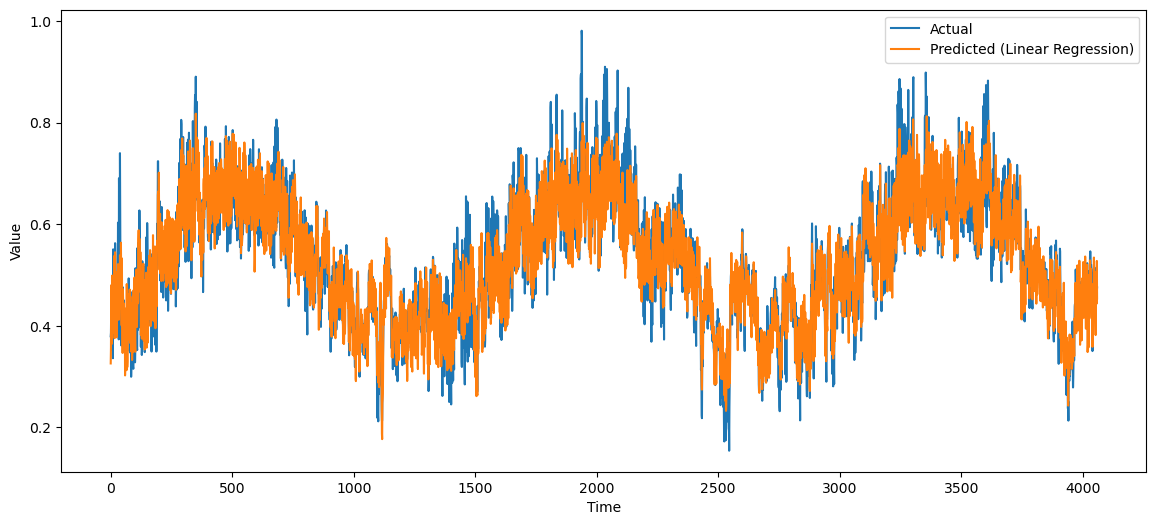

In [18]:
# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(Y_test, label='Actual')
plt.plot(predictions_linear, label='Predicted (Linear Regression)')
plt.xlabel('Time')
plt.ylabel('Scaled temprature') #in this case

plt.legend()
plt.show()